# SVM model with tabular data


https://monkeylearn.com/blog/introduction-to-support-vector-machines-svm/#:~:text=A%20support%20vector%20machine%20(SVM,able%20to%20categorize%20new%20text.

- binary classification algorithm, supervised learning
- calculates best decision boundary (eg. hyperplane) between data with different labels
- linear classifier = can only separate linearly separable data
- good for small datasets

Working with non-linear data:
- uses kernel trick: apply a kernel function (eg. dot product of feature vectors). work in the original feature space without computing the coordinates of data in a higher dimension. Its a more efficient way to transform data into a higher dimension where data is more linearly separable.
- This is more cost efficient than manually mapping data to a higher dimension (might require lots of dimensions to be added, complex calculations)



## A. Set up

### A.1 Loading dataset 

In [14]:
import numpy as np
import pandas as pd

df = pd.read_csv('../examples/adult_icu.csv')
# df.head()

### A.3 Loading variables

In [2]:
non_feature_cols = ['subject_id', 'hadm_id', 'icustay_id', 'train', 'mort_icu', 'adult_icu', 'chartext']
feature_cols = np.asarray(df.columns)
feature_cols = [feature for feature in feature_cols if feature not in non_feature_cols] # all feature columsn

label_col = "mort_icu"


## B. Data Splits

In [3]:
from sklearn.model_selection import train_test_split

# get train test split by index value
idx_train, idx_test, y_train, y_test = train_test_split(df.index, df[label_col].values, test_size=0.33,random_state=109)

# get train and test df
train_df = df.iloc[idx_train]
test_df = df.iloc[idx_test]

print("Train= x: " + str(train_df.shape) + " , y: " + str(y_train.shape))
print("Test= x: " + str(test_df.shape) + " , y: " + str(y_train.shape))

Train= x: (18323, 62) , y: (18323,)
Test= x: (9025, 62) , y: (18323,)


## C. Data Processing

https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114

Things to consider:
- data imputation / missing values
- Handling outliers
    - detect and remove
    - detect and capp 
- Log transform:
    - helps to handle skewed data and after transformation, the distribution becomes more approximate to normal.
    - In most of the cases the magnitude order of the data changes within the range of the data. For instance, the difference between ages 15 and 20 is not equal to the ages 65 and 70. In terms of years, yes, they are identical, but for all other aspects, 5 years of difference in young ages mean a higher magnitude difference. This type of data comes from a multiplicative process and log transform normalizes the magnitude differences like that.
    - It also decreases the effect of the outliers, due to the normalization of magnitude differences and the model become more robust.
    - NOTE: The data you apply log transform must have only positive values, otherwise you receive an error. Also, you can add 1 to your data before transform it. Thus, you ensure the output of the transformation to be positive.
- One-hot-encoding:
    - This method changes your categorical data, which is challenging to understand for algorithms, to a numerical format and enables you to group your categorical data without losing any information.
- scaling:
    - makes sure different scales don't affect model

### C.1 Feature scaling (normalizing / standardizing)

SVM:
- Recommend standardizing (from 0,1) because feature scales influence the optimal hyperplane

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/
https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

Scaling features:
- purpose: Having features on a similar scale can help the gradient descent converge more quickly towards the minima.
- distance based algorithms: we scale our data before employing a distance based algorithm so that all the features contribute equally to the result. 

Normalization: numbers scaled from 0 to 1 --> can use sk learn MinMaxScaler
- Normalization is good to use when you know that the distribution of your data does not follow a Gaussian distribution. This can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors and Neural Networks.

Standardizing: rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1.
- Standardization, on the other hand, can be helpful in cases where the data follows a Gaussian distribution. However, this does not have to be necessarily true. Also, unlike normalization, standardization does not have a bounding range. So, even if you have outliers in your data, they will not be affected by standardization.

- However, at the end of the day, the choice of using normalization or standardization will depend on your problem and the machine learning algorithm you are using. There is no hard and fast rule to tell you when to normalize or standardize your data. You can always start by fitting your model to raw, normalized and standardized data and compare the performance for best results.


Types of scalers:
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
- StandardScaler: removes the mean and scales the data to unit variance
    - outliers have an influence when computing the empirical mean and standard deviation which shrink the range of the feature values
    - cannot guarantee balanced feature scales in the presence of outliers
- minmax scaler: normalizing to [0,1], sensitive to outliers
- maxabs scaler: absolute values scaled to [0,1], sensitive to outliers
- robust scaler: the centering and scaling statistics based on percentiles
    - not influenced by a few number of very large marginal outliers. 
    - resulting range of the transformed feature values is larger and are approximately similar. 
    - Outliers themselves are still present in the transformed data
- power transformer: applies a power transformation to each feature to make the data more Gaussian-like. 
    - Currently, PowerTransformer implements the Yeo-Johnson and Box-Cox transforms
    -  finds the optimal scaling factor to stabilize variance and mimimize skewness through maximum likelihood estimation

- QuantileTransformer: 
    - has an additional output_distribution parameter allowing to match a Gaussian distribution instead of a uniform distribution. Note that this non-parametetric transformer introduces saturation artifacts for extreme values
    - also can apply a non-linear transformation such that the probability density function of each feature will be mapped to a uniform distribution. In this case, all the data will be mapped in the range [0, 1], even the outliers which cannot be distinguished anymore from the inliers
    - robust to outliers in the sense that adding or removing outliers in the training set will yield approximately the same transformation on held out data. But contrary to RobustScaler, QuantileTransformer will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1).

- normalizer:
    - rescales the vector for each sample to have unit norm, independently of the distribution of the samples


In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

def fit_scaler(train_df, features_list: list, scale_type: str):
    """
    Fit scaler on train data
    inputs:
    - train_df: dataframe of x train data
    - features_list: list of features to be scaled
    - scale_type: type of scale to use (ie. standardize, normalize)

    scalers takes input (num_samples, num_features) and scales all features
    """
    scaler_dict = {
        "standard" : StandardScaler(), 
        "minmax" : MinMaxScaler(feature_range=(0, 1)) , 
        "maxabs" : MaxAbsScaler(), 
        "robust": RobustScaler(quantile_range=(25, 75)),
        "power_yeo_johnson": PowerTransformer(method='yeo-johnson'),
        "power_box_cox" : PowerTransformer(method='box-cox'),
        "quartile_normal":  QuantileTransformer(output_distribution='normal'),
        "quartile_uniform": QuantileTransformer(output_distribution='uniform'),
        "normalizer": Normalizer()
    }
    
    scaler = scaler_dict[scale_type].fit(train_df[features_list])

    return scaler


In [5]:
from sklearn.preprocessing import StandardScaler

# All non-binary features need to be standardized
binary_features = ['subject_id', 'hadm_id', 'icustay_id', 'mort_icu', 'first_icu_stay', 'first_hosp_stay', 'adult_icu', 'eth_asian', 'eth_black', 'eth_hispanic', 'eth_other','eth_white', 'admType_ELECTIVE', 'admType_EMERGENCY', 'admType_NEWBORN', 'admType_URGENT', 'admType_ELECTIVE', 'train', 'chartext']

# Get all feature columns that are non-binary
nonbinary_features = [feature for feature in feature_cols if feature not in binary_features]
print("Non binary features that are standardized: " + str(nonbinary_features))

# Fit the standardized scaler on the TRAIN data
scaler = fit_scaler(train_df, nonbinary_features, "standard")

# Tranform both TRAIN and TEST data on the scaler fitted on TRAIN data
train_df[nonbinary_features] = scaler.transform(train_df[nonbinary_features])
test_df[nonbinary_features] = scaler.transform(test_df[nonbinary_features])

# train_df.head()

Non binary features that are standardized: ['age', 'heartrate_min', 'heartrate_max', 'heartrate_mean', 'sysbp_min', 'sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max', 'diasbp_mean', 'meanbp_min', 'meanbp_max', 'meanbp_mean', 'resprate_min', 'resprate_max', 'resprate_mean', 'tempc_min', 'tempc_max', 'tempc_mean', 'spo2_min', 'spo2_max', 'spo2_mean', 'glucose_min', 'glucose_max', 'glucose_mean', 'aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'creatinine', 'chloride', 'glucose', 'hematocrit', 'hemoglobin', 'lactate', 'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun', 'wbc']


### C.2 Obtain X_TRAIN, Y_TRAIN, X_TEST, Y_TEST

In [6]:
# identify feature columns
label_col = "mort_icu"
non_feature_cols = ['subject_id', 'hadm_id', 'icustay_id', 'train', 'mort_icu', 'adult_icu', 'chartext']
feature_cols = np.asarray(df.columns)
feature_cols = [feature for feature in feature_cols if feature not in non_feature_cols] # all feature columsn
num_features = len(feature_cols)

# x_train, y_train
num_train = len(train_df)
x_train = train_df[feature_cols].values.reshape(num_train, num_features)
y_train = train_df[label_col].values.reshape(num_train,)

print("x train: " + str(x_train.shape))
print("y train: " + str(y_train.shape))

# x_test, y_test
num_test= len(test_df)
x_test = test_df[feature_cols].values.reshape(num_test, num_features)
y_test = test_df[label_col].values.reshape(num_test,)

print("x train: " + str(x_test.shape))
print("y train: " + str(y_test.shape))

x train: (18323, 56)
y train: (18323,)
x train: (9025, 56)
y train: (9025,)


## D. SVM

### D.1 Kernel function:

Kernel trick:
https://medium.com/@zxr.nju/what-is-the-kernel-trick-why-is-it-important-98a98db0961d
- allows you to operate in the original feature space without computing the coordinates of the data in a higher dimensional space.
- can be applied to any linear classifier
- offer a more efficient and less expensive way to transform data into higher dimensions

Types of kernel functions:

https://data-flair.training/blogs/svm-kernel-functions/#:~:text=The%20function%20of%20kernel%20is,(RBF)%2C%20and%20sigmoid.

http://crsouza.com/2010/03/17/kernel-functions-for-machine-learning-applications/


- linear kernel:
    - inner product + optional constant
    - like standard PCA 

- polynomial kernel: 
    - non-stationary kernel
    - good for normalized data
    - popular in image processing

- gaussian radial basis function kernel:
    - There is an infinite number of dimensions in the feature space because it can be expanded by the Taylor Series.
    - general purpose, good when you have no prior knowledge about data
    - sigma (adjustable parameter) needs to be carefully tuned to problem. 
        - if overestimated, function will behave linearly (ie. lose non-linear power). 
        - if underestimated, function will lack regularitzation and decision boundary will be highly sensity to noise (ie. overfitted)

- inverse multiquadric kernel:
    - results in kernel matrix with full rank --> forms infinite dimension feature space

- exponential radial basis function kernel:
    - similar to gaussian kernel, without the square of norm
    - sigma (adjustable parameter) needs to be carefully tuned to problem. 
        - if overestimated, function will behave linearly (ie. lose non-linear power). 
        - if underestimated, function will lack regularitzation and decision boundary will be highly sensity to noise (ie. overfitted)

- laplace radial basis function kernel: 
    - general purpose, good when you have no prior knowledge about data
    - same as exponential rbf, but less sensitive to changes in sigma parameter
    - sigma (adjustable parameter) needs to be carefully tuned to problem. 
        - if overestimated, function will behave linearly (ie. lose non-linear power). 
        - if underestimated, function will lack regularitzation and decision boundary will be highly sensity to noise (ie. overfitted)

- ANOVA radial basis function kernel:
    - perform well on multidimensional regression problems 

- hyperbolic tangent (sigmoid / MLP) kernal:
    - comes from neural network field (bipolar sigmoid function often used as activation function)
    - SVM usign sigmoid kernal is the same as 2 layer perceptron network 
    - performs well in practise for SVM

- Rational quadratic kernel or multiquadric kernel:
    - can replace gaussian rbf kernel because its less computationally expensive

- cauchy kernel:
    - give long-range influence and sensitivity over high dimension space
    - long-tailed kernel

- circular kernel or spherical kernel:
    - used in geostatic application

- power kernel:
    - scale-invariant kernel
    - unrectified triangular kernel

- log kernel:
    - interesting for images


Cons of kernel trick:
- higher dimension --> increased chance of overfitting. therefore choosing the right kernel function and the right regulation method is key

### D.2 Hyperparameter tuning 
https://towardsdatascience.com/a-guide-to-svm-parameter-tuning-8bfe6b8a452c

C: penalty parameter
- tells algorithm how much you care about misclassified points
    - high: penalize misclassified more - more accurate to current data but could overfit
    - low: penalize misclassfied less - less accurate to current data but more generalizable

gamma: spread of kernel / decision region
    - low = curve of decision boundary is low (like a linear boundary)
    - high = curve of devision boundary is high (can overfit)

https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/svm/plot_svm_parameters_selection.html

Stratified K-Fold crossvalidation:
- to set hyperparameters (C, gamma)
- strafied = ensures that there are equal number of data from each label
- k = N : leave one out validation (predict on one sample)
- k = usually 5 or 10, but no formal rule
    - k gets larger = difference in size between training set and resampling subset gets smaller = bias decreases
    - 10 is good place to start


In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

def report_best_params(x_train: np.array, y_train: np.array, params: dict, estimator, n_splits: int):
    """
    x_train: np array of train data
    y_train: np array of train data labels
    params: range of parameters to test
    estimator: type of model
    n_splits: number of splits for cv validation
    """

    grid = GridSearchCV(estimator=estimator, param_grid=params, refit = True, cv= StratifiedKFold(n_splits=n_splits))
    grid.fit(x_train, y_train)

    print("The best classifier is: ", grid.best_estimator_)

    print("The best parameters are: " + str(grid.best_params_))

In [8]:
from sklearn.svm import SVC

#  define parameters to tune for svm     
    # refine these as you go
params = [{'kernel': ['rbf'], 'gamma': [0.1, 1, 100],'C': [0.1, 1, 100]}]

# uncomment for better range
# params = [{'kernel': ['rbf'], 'gamma': 10. ** np.arange(-5, 5),'C': 10. ** np.arange(-2, 5)},{'kernel': ['linear'], 'C': 10. ** np.arange(-2, 5)}]

report_best_params(x_train, y_train, params, SVC(), 10)

The best classifier is:  SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


TypeError: can only concatenate str (not "dict") to str

### D.3 SVM model with optimal parameters

In [9]:
kernel = "rbf"
c = 0.1
gamma = 0.1

model = SVC(kernel=kernel, C=c, gamma=gamma)
model.fit(x_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### D.4 Making and evaluating predictions

evaluate prediction using AUC score 
- AUC score: represents degree or measure of separability (ie. how well a model is able to distinguish between classes)
    - area under the ROC curve (TPR and FPR are clearly separated)

- scale-invariant. It measures how well predictions are ranked, rather than their absolute values.  
    - note: not good if you need well calibrated outputs
    
- classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.
    - note: not be good if cost of FP and FN are significantly different

AUC score: 0.7750250452075597


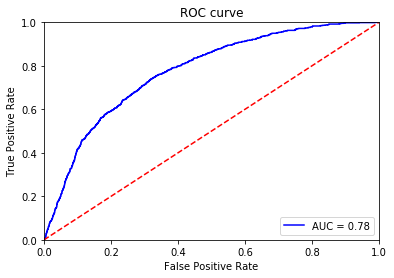

In [13]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

y_pred = model.predict(x_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

print("AUC score: " + str(roc_auc))

# evaluate prediction using ROC graph
plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()